In [ ]:
# @title Copyright & License (click to expand)
# MIT License

# Copyright (c) 2022 olsenlabmit

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

This notebook is to perform the calculations and reproduce the results of Case 1 in the manuscript, Jiale Shi, Nathan J. Rebello, Dylan Walsh, Weizhong Zou, Michael E. Deagen, Bruno Salomao Leao, Debra J. Audus, Bradley D. Olsen, "Quantifying Pairwise Chemical Similarity for Polymers"



<a target="_blank" href="https://colab.research.google.com/github/olsenlabmit/Polymer-Graph-Similarity/blob/main/notebook/Polymer_Similarity_Case1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" width="120" height="30"/>
</a>

# Import and install necessary libraries

In [ ]:
# Import Necessary Libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import shutil
import sys
import os.path

#Install necessary libraries
!pip install -q rdkit
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AtomPairs import Pairs


if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
        print("install cbc")
    else:
        try:
            !conda install -c conda-forge coincbc 
            print("install cbc-2")
        except:
            print("skip cbc")
            pass
            

assert(shutil.which("cbc") or os.path.isfile("cbc"))
    
from pyomo.environ import *

# Similarity Score Functions

## Earth Mover's Distance (EMD) Similarity Function

Similarity score of earth mover's distance for repeating units ensemble and end group ensemble

The EMD linear optimization code  refers [3.1. Transportation Networks, ND Pyomo Notebook](https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/03.01-Transportation-Networks.html)

In [ ]:
def Similarity_Score_EMD(query_smiles_list = None, 
                         query_smiles_weight_list = None, 
                         target_smiles_list = None, 
                         target_smiles_weight_list = None,
                         embedding_function = 'MorganFingerprint', #
                         similarity_score_function = 'Tanimoto'):
  
    # obtain the length of query smiles list and target smiles list
    
    query_smiles_list_length = len(query_smiles_list)  

    target_smiles_list_length = len(target_smiles_list)
    
    # check whether the query is identical with the target
    if set(query_smiles_list) == set(target_smiles_list):
        query_smiles_array = np.array(query_smiles_list)
        query_smiles_level_array = np.array(query_smiles_weight_list)
        inds_query = query_smiles_array.argsort()
        sorted_query_smiles_array = query_smiles_array[inds_query]
        sorted_query_smiles_level_array = query_smiles_level_array[inds_query]

        target_smiles_array = np.array(target_smiles_list)
        target_smiles_level_array = np.array(target_smiles_weight_list)
        inds_target = target_smiles_array.argsort()
        sorted_target_smiles_array = target_smiles_array[inds_target]
        sorted_target_smiles_level_array = target_smiles_level_array[inds_target]

        if np.array_equal(sorted_query_smiles_array, sorted_target_smiles_array) and np.array_equal(sorted_query_smiles_level_array, sorted_target_smiles_level_array):
            return 1.0

        query_smiles_reduced_list = list(set(query_smiles_list))
        query_smiles_reduced_list_number = []
        for i in range(0, len(query_smiles_reduced_list)):
            query_smiles_reduced_list_number_i  = 0
            for j in range(0, len(query_smiles_list)):
                if query_smiles_reduced_list[i] == query_smiles_list[j]:
                    query_smiles_reduced_list_number_i = query_smiles_reduced_list_number_i   + query_smiles_weight_list[j]
            query_smiles_reduced_list_number.append(query_smiles_reduced_list_number_i/sum(query_smiles_weight_list))

        target_smiles_reduced_list = list(set(target_smiles_list))
        target_smiles_reduced_list_number = []
        for i in range(0, len(target_smiles_reduced_list)):
            target_smiles_reduced_list_number_i  = 0
            for j in range(0, len(target_smiles_list)):
                if target_smiles_reduced_list[i] == target_smiles_list[j]:
                    target_smiles_reduced_list_number_i = target_smiles_reduced_list_number_i   + target_smiles_weight_list[j]
            target_smiles_reduced_list_number.append(target_smiles_reduced_list_number_i/sum(target_smiles_weight_list))

        if query_smiles_reduced_list_number == target_smiles_reduced_list_number:
            return 1.0

    # transfer SMILES to fingerprints
    if embedding_function == 'RDKFingerprint':    
        query_mol_list = [Chem.MolFromSmiles(x) for x in query_smiles_list]
        query_fingerprint_list = [Chem.RDKFingerprint(x) for x in query_mol_list]
        target_mol_list = [Chem.MolFromSmiles(x) for x in target_smiles_list]
        target_fingerprint_list = [Chem.RDKFingerprint(x) for x in target_mol_list]

    elif embedding_function == 'MorganFingerprint':    
        query_mol_list = [Chem.MolFromSmiles(x) for x in query_smiles_list]
        query_fingerprint_list = [AllChem.GetMorganFingerprintAsBitVect(x,2,nBits=2048) for x in query_mol_list]
        target_mol_list = [Chem.MolFromSmiles(x) for x in target_smiles_list]
        target_fingerprint_list = [AllChem.GetMorganFingerprintAsBitVect(x,2,nBits=2048) for x in target_mol_list]

    elif embedding_function == 'MACCSkeys':    
        query_mol_list = [Chem.MolFromSmiles(x) for x in query_smiles_list]
        query_fingerprint_list = [MACCSkeys.GenMACCSKeys(x) for x in query_mol_list]
        target_mol_list = [Chem.MolFromSmiles(x) for x in target_smiles_list]
        target_fingerprint_list = [MACCSkeys.GenMACCSKeys(x) for x in target_mol_list]


    else:
        print(embedding_function + " is not included in the current vision, please choose an available embedding function:");
        print("MorganFingerprint, RDKFingerprint, MACCSkeys.")
        return False         

    # Define the required three sets

    Demand = {} # query
    Supply = {} # target
    T = {}      # transport flow

    # define the weight for SMILES in query, w_i
    if len(set(query_smiles_weight_list)) ==1:
        for i in range(0, query_smiles_list_length):
            Demand["P" + str(i+1)] = 1/query_smiles_list_length
    else:
        query_weight_sum = 0.0
        for i in range(0, query_smiles_list_length):
            query_weight_sum = query_weight_sum + query_smiles_weight_list[i]

        for i in range(0, query_smiles_list_length):
            Demand["P" + str(i+1)] = query_smiles_weight_list[i]/query_weight_sum

    # define weight for SMILES in target, w_j
    if len(set(target_smiles_weight_list)) ==1:       
        for j in range(0,target_smiles_list_length):
            Supply["Q" + str(j+1)] = 1/target_smiles_list_length
    else:
        target_weight_sum = 0.0
        for j in range(0, target_smiles_list_length):
            target_weight_sum = target_weight_sum + target_smiles_weight_list[j]

        for j in range(0, target_smiles_list_length):
            Supply["Q" + str(j+1)] = target_smiles_weight_list[j]/target_weight_sum



    # similarity function to calculate d_ij
    if similarity_score_function == 'Tanimoto':
        for i in range(0,query_smiles_list_length):
            for j in range(0,target_smiles_list_length):
                # calculate the fingerprint similarityscore between query[i],target[j] and input the distance = 1- similarityscore
                T[("P" + str(i+1), "Q" + str(j+1))] = 1 - DataStructs.FingerprintSimilarity(query_fingerprint_list[i],target_fingerprint_list[j])
                #print("P" + str(i+1), "->Q" + str(j+1), T[("P" + str(i+1), "Q" + str(j+1))] )

    elif similarity_score_function == 'Dice':
        for i in range(0,query_smiles_list_length):
            for j in range(0,target_smiles_list_length):
                # calculate the fingerprint similarityscore between query[i],target[j] and input the distance = 1- similarityscore
                T[("P" + str(i+1), "Q" + str(j+1))] = 1 - DataStructs.FingerprintSimilarity(query_fingerprint_list[i],target_fingerprint_list[j], metric=DataStructs.DiceSimilarity)
                #print("P" + str(i+1), "->Q" + str(j+1), T[("P" + str(i+1), "Q" + str(j+1))] )

    elif similarity_score_function == 'Cosine':
        for i in range(0,query_smiles_list_length):
            for j in range(0,target_smiles_list_length):
                # calculate the fingerprint similarityscore between query[i],target[j] and input the distance = 1- similarityscore
                T[("P" + str(i+1), "Q" + str(j+1))] = 1 - DataStructs.FingerprintSimilarity(query_fingerprint_list[i],target_fingerprint_list[j], metric=DataStructs.CosineSimilarity)
                #print("P" + str(i+1), "->Q" + str(j+1), T[("P" + str(i+1), "Q" + str(j+1))] )
       
    else:
        print(similarity_score_function + " is not included in the current vision, please choose an available similarity function:");
        print("Tanimoto, Dice, or Cosine")
        return

    

    #print(len(Demand), len(Supply), len(T))
    # Step 0: Create an instance of the model
    model = ConcreteModel()
    model.dual = Suffix(direction=Suffix.IMPORT)

    # Step 1: Define index sets
    CUS = list(Demand.keys())
    SRC = list(Supply.keys())

    # Step 2: Define the decision 
    model.x = Var(CUS, SRC, domain = NonNegativeReals)

    # Step 3: Define Objective
    model.Cost = Objective(
    expr = sum([T[c,s]*model.x[c,s] for c in CUS for s in SRC]),
    sense = minimize)

    # Step 4: Constraints
    model.src = ConstraintList()
    for s in SRC:
        model.src.add(sum([model.x[c,s] for c in CUS]) == Supply[s])
        
    model.dmd = ConstraintList()
    for c in CUS:
        model.dmd.add(sum([model.x[c,s] for s in SRC]) == Demand[c])

    
    results = SolverFactory('cbc').solve(model)


    if 'ok' == str(results.Solver.status):
        #print("EMD(P,Q) = ",model.Cost())
        #print ("\n")
        #print("S(P,Q) = ", 1- model.Cost())
        SimilarityScore = 1- model.Cost()
        return SimilarityScore
        
    else:
        print("No Valid Solution Found")
        return False



## Graph Edit Distance (GED) Similarity Function

$GED(g_1, g_2)$ is calculated via networkx function [graph_edit_distance](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.similarity.graph_edit_distance.html)

Mapping the GED to a topological similarity score in the range of (0,1] via a exponential decay function on the normalized GED, 

$S_{\rm TOP} = \exp(-\frac{\alpha \cdot GED}{(N_1 + N_2)/2})$

In [ ]:
# Graph Edit Distance
def Similarity_Score_Graph_Edit_Distance(Graph1 = None, 
                         Graph2 = None, 
                         alpha = 1):
    if Graph1 == None:
        print("Missing Graph1")
        return
    if Graph2 == None:
        print("Missing Graph2")
        return
    
    
    Graph1_number_nodes = Graph1.number_of_nodes() 
    Graph2_number_nodes = Graph2.number_of_nodes() 
    
    graph_edit_distance = nx.graph_edit_distance(Graph1, Graph2)
    
    topology_similarity_score = np.exp(-alpha*graph_edit_distance/((Graph1_number_nodes+ Graph2_number_nodes)/2))

    return topology_similarity_score 

## Weighted Mean Function with different weights and different mean functions

### weighted geometric mean
### weighted arithmetic mean

In [ ]:
def Combined_Similarity_Score(Repeat_Unit_Similarity_Score = None,
                              Repeat_Unit_Weight = 0.5,
                              Graph_Similarity_Score = None,
                              Graph_Weight = 0.5,
                              End_Group_Similarity_Score = None,
                              End_Group_Weight = 0.0,
                              Mean_Function = 'arithmetic'):
  
    # Verify whether the weight sum is normalized.
    if  abs(Repeat_Unit_Weight + Graph_Weight +  End_Group_Weight -1 ) >=0.000000000001:
        print("Weight Sum is not normalized.")
        return False

    # Not consider the end group
    if End_Group_Similarity_Score == None:

        if Mean_Function == 'arithmetic':
            combined_similarity_score = (Repeat_Unit_Weight * Repeat_Unit_Similarity_Score + Graph_Weight * Graph_Similarity_Score)

        elif Mean_Function == 'geometric':
            combined_similarity_score = pow(Repeat_Unit_Similarity_Score,Repeat_Unit_Weight)*pow(Graph_Similarity_Score,Graph_Weight)

        else:
            print("Your input mean function ", Mean_Function, " is not implemented, please choose those implemented mean function, like arithmetic, geometric")
    
    # consider the end group
    else:
      
        if Mean_Function == 'arithmetic':
            combined_similarity_score = Repeat_Unit_Weight * Repeat_Unit_Similarity_Score + Graph_Weight * Graph_Similarity_Score + End_Group_Weight * End_Group_Similarity_Score

        elif Mean_Function == 'geometric':
            combined_similarity_score = pow(Repeat_Unit_Similarity_Score,Repeat_Unit_Weight)*pow(Graph_Similarity_Score,Graph_Weight)*pow(End_Group_Similarity_Score, End_Group_Weight)

        else:
            print("Your input mean function ", Mean_Function, " is not implemented, please choose those implemented mean function, like arithmetic, geometric")
            
    return combined_similarity_score


## Overall pairwise similarity score $S_{\rm OA}$ between the query polymer and the target polymer

In [ ]:
def Similarity_Score_Two_Polymer(query = None,
                                 target = None,
                                 embedding_function = 'RDKFingerprint', #Embedding function
                                 similarity_score_function = 'Tanimoto', # Similarity function for two vectors
                                 alpha=1, #reduced parameter for the exponential decay function
                                 Repeat_Unit_Weight=0.5,
                                 Graph_Weight=0.5,
                                 End_Group_Weight = 0.0,
                                 Mean_Function = 'geometric',
                                 details_print = False,
                                 return_with_components = False):

    if query == None or target == None:
        print ("Either query polymer or target polymer is missing! Please check the input.")
        return False
    S_repeat_unit = Similarity_Score_EMD(query_smiles_list = query.repeat_unit_smiles_list, 
                     query_smiles_weight_list = query.repeat_unit_smiles_weight_list, 
                     target_smiles_list = target.repeat_unit_smiles_list, 
                     target_smiles_weight_list = target.repeat_unit_smiles_weight_list,	
                     embedding_function = embedding_function,
                     similarity_score_function = similarity_score_function)
    
    S_graph = Similarity_Score_Graph_Edit_Distance(Graph1=query.graph_representation, 
                                                   Graph2=target.graph_representation, 
                                                   alpha=alpha)

    S_end_group = 1.0

    if len(query.end_group_smiles_list) == 0 and  len(target.end_group_smiles_list) == 0:
        S_end_group = 1.0
    
    elif (len(query.end_group_smiles_list) == 0 and len(target.end_group_smiles_list) != 0 ) or (len(query.end_group_smiles_list) != 0 and len(target.end_group_smiles_list) == 0 ):
        S_end_group = 0.05

    else: 

        S_end_group = Similarity_Score_EMD(query_smiles_list = query.end_group_smiles_list, 
                     query_smiles_weight_list = query.end_group_smiles_weight_list, 
                     target_smiles_list = target.end_group_smiles_list, 
                     target_smiles_weight_list = target.end_group_smiles_weight_list,	
                     embedding_function = embedding_function,
                     similarity_score_function = similarity_score_function)
            
    S_combined = Combined_Similarity_Score(Repeat_Unit_Similarity_Score=S_repeat_unit ,
                                       Repeat_Unit_Weight=Repeat_Unit_Weight,
                                       Graph_Similarity_Score=S_graph,
                                       Graph_Weight=Graph_Weight,
                                       End_Group_Similarity_Score = S_end_group,
                                       End_Group_Weight = End_Group_Weight,
                                       Mean_Function = Mean_Function)
        
    if details_print == True:
            print("Details of the Similarity Score:\n")
            print("Similarity score on Repeating Unit = ", S_repeat_unit, ", Weight for Repeating Unit = ", Repeat_Unit_Weight)
            print("Similarity score on Graph = ", S_graph, ", Weight for Graph = ", Graph_Weight)
            print("Similarity score on End Group = ", S_end_group, ", Weight for End Group = ", End_Group_Weight )
            print("Overall Pairwise Similarity score Combined in " + Mean_Function + " mean = ", S_combined)
            print("\n")
    if return_with_components == True:
        return S_combined, S_repeat_unit, S_graph, S_end_group

    return S_combined     


# Define Polymer Class for import Polymer data

## (1) Repeat Units SMILES and Weights
## (2) End Group SMILES and Weights
## (3) Topological Graph Representation

In [ ]:
class Polymer:
  def __init__(self, 
               repeat_unit_smiles_list= None, 
               repeat_unit_smiles_weight_list= None, 
               end_group_smiles_list= None, 
               end_group_smiles_weight_list= None,
               graph_representation= None):
    
      if  repeat_unit_smiles_list == None:
          print("Error: Repeat unit SMILES are missing. Please define the repeat unit SMILES.") 
          return 

      else: 
          self.repeat_unit_smiles_list = repeat_unit_smiles_list
      

      if repeat_unit_smiles_weight_list == None:
          print("Error: Repeat unit weights are missing. Please re-enter the correct repeat unit weights.\n")
          return

      elif len(repeat_unit_smiles_weight_list) != len(repeat_unit_smiles_list):
          print("Error: The import repeat unit weights are not correct. Please re-enter the correct repeat unit SMILES and weights.\n")
          return
      else:
          self.repeat_unit_smiles_weight_list = repeat_unit_smiles_weight_list

      if end_group_smiles_list == None and end_group_smiles_weight_list == None:
          self.end_group_smiles_list = []
          self.end_group_smiles_weight_list = []
          print("Notice: The defined Polymer has NO end group.\nIf this is what you want, this message is NOT Error. \nOtherwise, please enter the correct End group SMILES and weights.\n")

      elif (end_group_smiles_list == None and end_group_smiles_weight_list != None) or (end_group_smiles_list != None and end_group_smiles_weight_list == None):
          print("Error: End group SMILES and weights are not matching. Please re-enter the correct End group SMILES and weights.\n")
          return

      else:
          if len(end_group_smiles_list) != len(end_group_smiles_weight_list):
              print("Error: End group SMILES and weights are not matching. Please re-enter the correct End group SMILES and weights.\n")
              return
          else:
              if len(end_group_smiles_list) ==0 and  len(end_group_smiles_weight_list) ==0:
                  print("Notice: The defined Polymer has NO end group. \nIf this is what you want, this message is NOT Error. \n Otherwise, please enter the correct End group SMILES and weights.\n")

              self.end_group_smiles_list = end_group_smiles_list
              self.end_group_smiles_weight_list = end_group_smiles_weight_list   

      if graph_representation == None:
          print("Error: Topology graph representation is missing. Please define the topology graph representation.\n")
          return
      else:
          self.graph_representation = graph_representation

## Topological graph representations for diblock polymers in Case 1

Since four diblock copolymer in Case 1 all share the same topological graph representation, therefore, we only need to define one diblock topological graph representation.

diblock_top_graph_representation number of nodes:  8
diblock_top_graph_representation number of edges:  11


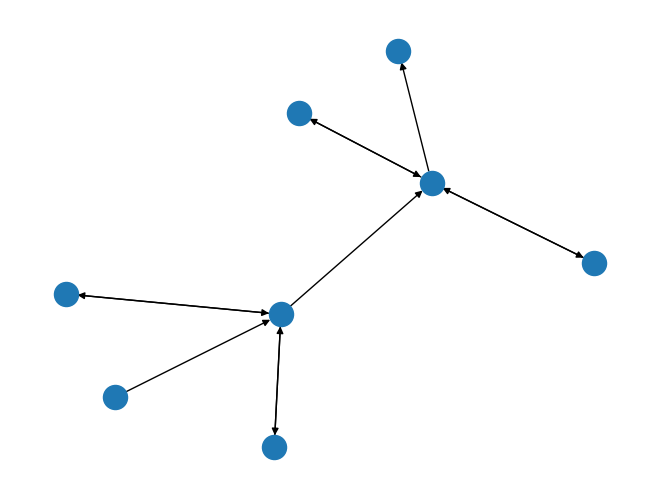

In [ ]:
diblock_top_graph_representation = nx.MultiDiGraph()
diblock_top_graph_representation.add_nodes_from([1,2,3,4,5,6,7,8])
diblock_top_graph_representation.add_edges_from([(1, 2),(2, 3),(3, 4), (2, 5),(5, 2),(3, 6),(6, 3),(2,7),(7,2),(3,8),(8,3)])
nx.draw(diblock_top_graph_representation)
print("diblock_top_graph_representation number of nodes: ",diblock_top_graph_representation.number_of_nodes())
print("diblock_top_graph_representation number of edges: ",diblock_top_graph_representation.number_of_edges())

# Define Polymers in Case 1

## Polymer C1-1

In [ ]:
Polymer_C1_1 = Polymer(repeat_unit_smiles_list = ['*CC(*)C', '*CC(*)c1ccccc1'], 
                      repeat_unit_smiles_weight_list = [1,1], 
                      end_group_smiles_list = ['*C(C)(C)C#N','*C(C)(C)C#N'], 
                      end_group_smiles_weight_list = [1,1], 
                      graph_representation = diblock_top_graph_representation)

## Polymer C1-2

In [ ]:
Polymer_C1_2 = Polymer(repeat_unit_smiles_list= ['*CC(*)(C)C(=O)OC','*CC(*)c1ccccc1'], 
                      repeat_unit_smiles_weight_list = [1,1],
                      end_group_smiles_list = ['*C(C)(C)C#N','*C(C)(C)C#N'],
                      end_group_smiles_weight_list  = [1,1],
                      graph_representation = diblock_top_graph_representation)



## Polymer C1-3

In [ ]:
Polymer_C1_3 = Polymer(repeat_unit_smiles_list= ['*CC(*)C','*CC(*)c1ccc(C(=O)OC)cc1'], 
                      repeat_unit_smiles_weight_list = [1,1],
                      end_group_smiles_list = ['*C(C)(C)C#N','*C(C)(C)C#N'],
                      end_group_smiles_weight_list  = [1,1],
                      graph_representation = diblock_top_graph_representation)


## Polymer C1-4

In [ ]:
Polymer_C1_4 = Polymer(repeat_unit_smiles_list= ['*CC(*)(C)C(=O)OC','*CC(*)c1ccc(C(=O)OC)cc1'], 
                      repeat_unit_smiles_weight_list = [1,1],
                      end_group_smiles_list = ['*C(C)(C)C#N','*C(C)(C)C#N'],
                      end_group_smiles_weight_list  = [1,1],
                      graph_representation = diblock_top_graph_representation)

# Run code to calculate similarity score (test some examples)
## Calculate the pairwise similarity score between C1-1 and C1-2

In [ ]:
Similarity_Score_Two_Polymer(query = Polymer_C1_1,
                             target = Polymer_C1_2,
                             embedding_function = 'MorganFingerprint',
                             similarity_score_function = 'Tanimoto',
                             alpha=1,
                             Repeat_Unit_Weight=0.475,
                             Graph_Weight=0.475,
                             End_Group_Weight = 0.05,
                             Mean_Function = 'geometric',
                             details_print=True,
                             return_with_components = False)

Details of the Similarity Score:

Similarity score on Repeating Unit =  0.5769230769230769 , Weight for Repeating Unit =  0.475
Similarity score on Graph =  1.0 , Weight for Graph =  0.475
Similarity score on End Group =  1.0 , Weight for End Group =  0.05
Overall Pairwise Similarity score Combined in geometric mean =  0.7700714239676517




0.7700714239676517

## Calculate the pairwise similarity score between C1-1 and C1-3

In [ ]:
Similarity_Score_Two_Polymer(query = Polymer_C1_1,
                             target = Polymer_C1_3,
                             embedding_function = 'MorganFingerprint',
                             similarity_score_function = 'Tanimoto',
                             alpha=1,
                             Repeat_Unit_Weight=0.475,
                             Graph_Weight=0.475,
                             End_Group_Weight = 0.05,
                             Mean_Function = 'geometric',
                             details_print=True,
                             return_with_components = False)

Details of the Similarity Score:

Similarity score on Repeating Unit =  0.71875 , Weight for Repeating Unit =  0.475
Similarity score on Graph =  1.0 , Weight for Graph =  0.475
Similarity score on End Group =  1.0 , Weight for End Group =  0.05
Overall Pairwise Similarity score Combined in geometric mean =  0.854819621538289




0.854819621538289

## Calculate the pairwise similarity score between C1-1 and C1-4

In [ ]:
Similarity_Score_Two_Polymer(query = Polymer_C1_1,
                             target = Polymer_C1_4,
                             embedding_function = 'MorganFingerprint',
                             similarity_score_function = 'Tanimoto',
                             alpha=1,
                             Repeat_Unit_Weight=0.475,
                             Graph_Weight=0.475,
                             End_Group_Weight = 0.05,
                             Mean_Function = 'geometric',
                             details_print=True,
                             return_with_components = False)

Details of the Similarity Score:

Similarity score on Repeating Unit =  0.29567307692307687 , Weight for Repeating Unit =  0.475
Similarity score on Graph =  1.0 , Weight for Graph =  0.475
Similarity score on End Group =  1.0 , Weight for End Group =  0.05
Overall Pairwise Similarity score Combined in geometric mean =  0.5605774141216268




0.5605774141216268

# Calculate the whole similarity matrix for Polymers in Case 1

In [ ]:
Polymer_C1 = [Polymer_C1_1, Polymer_C1_2, Polymer_C1_3, Polymer_C1_4]

In [ ]:
Polymer_C1_RU_matrix =  np.ones([4,4])
Polymer_C1_TOP_matrix = np.ones([4,4])
Polymer_C1_EG_matrix =  np.ones([4,4])
Polymer_C1_OA_matrix = np.ones([4,4])

In [ ]:
for i in range(0,3):
    for j in range(i+1,4):
        SOAij, SRUij, STOPij, SEGij = Similarity_Score_Two_Polymer(query = Polymer_C1[i],
                             target = Polymer_C1[j],
                             embedding_function = 'MorganFingerprint',
                             similarity_score_function = 'Tanimoto',
                             alpha=1,
                             Repeat_Unit_Weight=0.475,
                             Graph_Weight=0.475,
                             End_Group_Weight = 0.05,
                             Mean_Function = 'geometric',
                             details_print=False,
                             return_with_components = True)
        
        Polymer_C1_OA_matrix[i,j] = SOAij
        Polymer_C1_OA_matrix[j,i] = SOAij


        Polymer_C1_RU_matrix[i,j] = SRUij
        Polymer_C1_RU_matrix[j,i] = SRUij

        Polymer_C1_TOP_matrix[i,j] = STOPij
        Polymer_C1_TOP_matrix[j,i] = STOPij

        Polymer_C1_EG_matrix[i,j] = SEGij
        Polymer_C1_EG_matrix[j,i] = SEGij

# Visualize the Similarity Matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

##     $S_{\rm RU}$

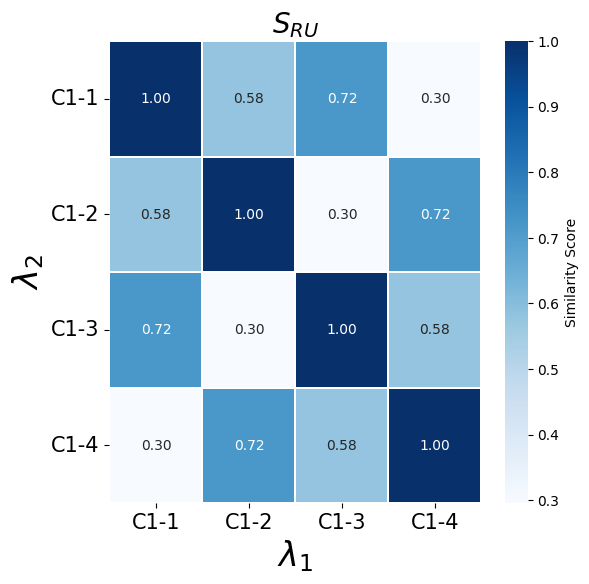

In [ ]:
fig, ax = plt.subplots(figsize=(6,6),sharey=True )

x_labels = ["C1-1", "C1-2", "C1-3", "C1-4" ]
y_labels = ["C1-1", "C1-2", "C1-3", "C1-4"]

sns.heatmap(Polymer_C1_RU_matrix, linewidth=0.3, annot=True, fmt=".2f" , cmap="Blues", cbar_kws={'label': 'Similarity Score'})
ax.set_title(r"$S_{RU}$", fontsize=20)
ax.set_xticklabels(x_labels, rotation=0, fontsize = 15,horizontalalignment='center')
ax.set_yticklabels(y_labels, rotation=360, fontsize = 15, horizontalalignment='right')
ax.set_xlabel(r"$\lambda_1$", size =24)
ax.set_ylabel(r"$\lambda_2$", size = 24)

plt.show()

##     $S_{\rm TOP}$

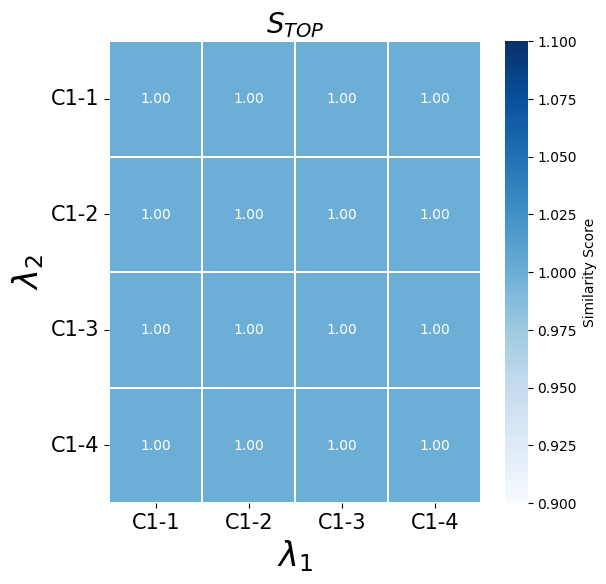

In [ ]:
fig, ax = plt.subplots(figsize=(6,6),sharey=True )

x_labels = ["C1-1", "C1-2", "C1-3", "C1-4" ]
y_labels = ["C1-1", "C1-2", "C1-3", "C1-4"]

sns.heatmap(Polymer_C1_TOP_matrix, linewidth=0.3, annot=True, fmt=".2f" , cmap="Blues", cbar_kws={'label': 'Similarity Score'})
ax.set_title(r"$S_{TOP}$", fontsize=20)
ax.set_xticklabels(x_labels, rotation=0, fontsize = 15,horizontalalignment='center')
ax.set_yticklabels(y_labels, rotation=360, fontsize = 15, horizontalalignment='right')
ax.set_xlabel(r"$\lambda_1$", size =24)
ax.set_ylabel(r"$\lambda_2$", size = 24)

plt.show()

##     $S_{\rm EG}$

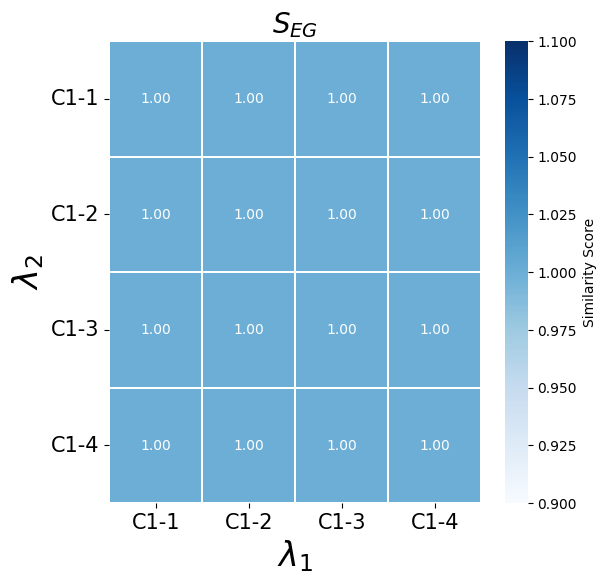

In [ ]:
fig, ax = plt.subplots(figsize=(6,6),sharey=True )

x_labels = ["C1-1", "C1-2", "C1-3", "C1-4" ]
y_labels = ["C1-1", "C1-2", "C1-3", "C1-4"]

sns.heatmap(Polymer_C1_EG_matrix, linewidth=0.3, annot=True, fmt=".2f" , cmap="Blues", cbar_kws={'label': 'Similarity Score'})
ax.set_title(r"$S_{EG}$", fontsize=20)
ax.set_xticklabels(x_labels, rotation=0, fontsize = 15,horizontalalignment='center')
ax.set_yticklabels(y_labels, rotation=360, fontsize = 15, horizontalalignment='right')
ax.set_xlabel(r"$\lambda_1$", size =24)
ax.set_ylabel(r"$\lambda_2$", size = 24)

plt.show()

##     $S_{\rm OA}$

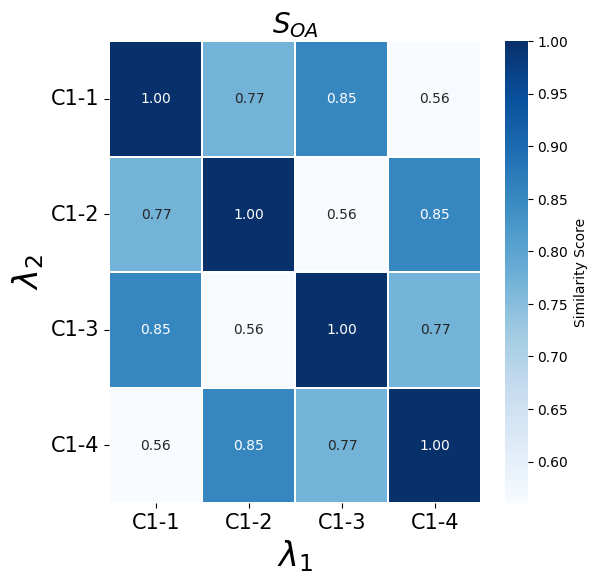

In [ ]:
fig, ax = plt.subplots(figsize=(6,6),sharey=True )

x_labels = ["C1-1", "C1-2", "C1-3", "C1-4" ]
y_labels = ["C1-1", "C1-2", "C1-3", "C1-4"]

sns.heatmap(Polymer_C1_OA_matrix, linewidth=0.3, annot=True, fmt=".2f" , cmap="Blues", cbar_kws={'label': 'Similarity Score'})
ax.set_title(r"$S_{OA}$", fontsize=20)
ax.set_xticklabels(x_labels, rotation=0, fontsize = 15,horizontalalignment='center')
ax.set_yticklabels(y_labels, rotation=360, fontsize = 15, horizontalalignment='right')
ax.set_xlabel(r"$\lambda_1$", size =24)
ax.set_ylabel(r"$\lambda_2$", size = 24)

plt.show()